In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils import model_zoo

__all__ = ['GoogLeNet', 'googlenet']

model_urls = {
    # GoogLeNet ported from TensorFlow
    'googlenet': 'https://download.pytorch.org/models/googlenet-1378be20.pth',
}


def googlenet(pretrained=False, **kwargs):
    r"""GoogLeNet (Inception v1) model architecture from
    `"Going Deeper with Convolutions" <http://arxiv.org/abs/1409.4842>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    if pretrained:
        if 'transform_input' not in kwargs:
            kwargs['transform_input'] = True
        kwargs['init_weights'] = False
        model = GoogLeNet(**kwargs)
        model.load_state_dict(model_zoo.load_url(model_urls['googlenet']))
        return model

    return GoogLeNet(**kwargs)


class GoogLeNet(nn.Module):

    def __init__(self, num_classes=1000, aux_logits=True, transform_input=False, init_weights=True):
        super(GoogLeNet, self).__init__()
        self.aux_logits = aux_logits
        self.transform_input = transform_input

        self.conv1 = BasicConv2d(3, 64, kernel_size=7, stride=2, padding=3)
        self.maxpool1 = nn.MaxPool2d(3, stride=2, ceil_mode=True)
        self.conv2 = BasicConv2d(64, 64, kernel_size=1)
        self.conv3 = BasicConv2d(64, 192, kernel_size=3, padding=1)
        self.maxpool2 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception3a = Inception(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = Inception(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, ceil_mode=True)

        self.inception4a = Inception(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = Inception(512, 160, 112, 224, 24, 64, 64, final=True)
        self.inception4c = Inception(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = Inception(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = Inception(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(2, stride=2, ceil_mode=True)

        self.inception5a = Inception(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = Inception(832, 384, 192, 384, 48, 128, 128)
        if aux_logits:
            self.aux1 = InceptionAux(512, num_classes)
            self.aux2 = InceptionAux(528, num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(0.4)
        self.fc = nn.Linear(1024, num_classes)

        if init_weights:
            self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0.2)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        if self.transform_input:
            x_ch0 = torch.unsqueeze(x[:, 0], 1) * (0.229 / 0.5) + (0.485 - 0.5) / 0.5
            x_ch1 = torch.unsqueeze(x[:, 1], 1) * (0.224 / 0.5) + (0.456 - 0.5) / 0.5
            x_ch2 = torch.unsqueeze(x[:, 2], 1) * (0.225 / 0.5) + (0.406 - 0.5) / 0.5
            x = torch.cat((x_ch0, x_ch1, x_ch2), 1)

        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.maxpool2(x)

        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)
        x = self.inception4a(x)
        if self.training and self.aux_logits:
            aux1 = self.aux1(x)

        x = self.inception4b(x)
        return x
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.training and self.aux_logits:
            aux2 = self.aux2(x)

        x = self.inception4e(x)
        x = self.maxpool4(x)
        x = self.inception5a(x)
        x = self.inception5b(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.dropout(x)
        x = self.fc(x)
        if self.training and self.aux_logits:
            return aux1, aux2, x
        return x


class Inception(nn.Module):

    def __init__(self, in_channels, ch1x1, ch3x3red, ch3x3, ch5x5red, ch5x5, pool_proj, final=False):
        super(Inception, self).__init__()

        self.branch1 = BasicConv2d(in_channels, ch1x1, kernel_size=1)

        self.branch2 = nn.Sequential(
            BasicConv2d(in_channels, ch3x3red, kernel_size=1),
            BasicConv2d(ch3x3red, ch3x3, kernel_size=3, padding=1)
        )

        self.branch3 = nn.Sequential(
            BasicConv2d(in_channels, ch5x5red, kernel_size=1),
            BasicConv2d(ch5x5red, ch5x5, kernel_size=3, padding=1)
        )

        self.branch4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=3, stride=1, padding=1, ceil_mode=True),
            BasicConv2d(in_channels, pool_proj, kernel_size=1, final=final)
        )

    def forward(self, x):
        branch1 = self.branch1(x)
        branch2 = self.branch2(x)
        branch3 = self.branch3(x)
        branch4 = self.branch4(x)

        outputs = [branch1, branch2, branch3, branch4]
        return torch.cat(outputs, 1)


class InceptionAux(nn.Module):

    def __init__(self, in_channels, num_classes):
        super(InceptionAux, self).__init__()
        self.conv = BasicConv2d(in_channels, 128, kernel_size=1)

        self.fc1 = nn.Linear(2048, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = F.adaptive_avg_pool2d(x, (4, 4))

        x = self.conv(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x), inplace=True)
        x = F.dropout(x, 0.7, training=self.training)
        x = self.fc2(x)

        return x


class BasicConv2d(nn.Module):

    def __init__(self, in_channels, out_channels, final=False, **kwargs):
        super(BasicConv2d, self).__init__()
        self.final = final
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        if self.final:
            return x
        x = self.bn(x)
        return F.relu(x, inplace=True)

In [3]:
import time
from skimage.io import imsave
from dreamz.utils import get_latest_filename, tch_im_to_np
from dreamz.cppn import get_xy_mesh, CPPNNet
from dreamz.render import train_visualiser
from dreamz.torch_utils import Lambda, adjust_learning_rate
from dreamz.cppn import composite_activation
import torch
from torch import nn
from torchvision import models
from torch.nn import functional as F
from torch import optim
import numpy as np


def train(size, widths, imagenet_model, chan_to_opt, log_interval):
    viz = CPPNNet(widths, input_channels=3)
    viz = viz.to(device)
    viz = nn.DataParallel(viz)
    mean = torch.FloatTensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1).to(device)
    std = torch.FloatTensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1).to(device)
    
    def get_alphas(batch_size, device):
#         alphas = torch.linspace(-1, 0.9, batch_size) + torch.rand(size=[batch_size]) * 0.1
        alphas = torch.randn(size=[batch_size])
        alphas = alphas.to(device)
        return alphas

    def mse_loss_fn(ims, alphas, distance_constant=0.2):
        ims = ims.view(ims.shape[0], -1)
        actual_distances = torch.abs(ims.unsqueeze(0) - ims.unsqueeze(0).permute(1, 0, 2)).mean(2)
        return -torch.mean(actual_distances)
#         targ_distances = distance_constant * torch.abs(alphas.unsqueeze(0) - alphas.unsqueeze(1))
#         return torch.mean(actual_distances - targ_distances)
    
    def imgnet_objective(output, alphas):
        r = imagenet_model((output - mean) / std)
    #     return torch.mean((r - targ) ** 2)
        loss = -r[:, chan_to_opt].mean()
        mse_loss = mse_loss_fn(output, alphas)
        loss = loss + mse_loss * 0
        return loss
    
    batch_size = 32

    xy = get_xy_mesh(size).to(device)
    xy = xy.repeat([batch_size, 1, 1, 1])

    def im_gen_fn(pct_done=0.0):
        alphas = get_alphas(batch_size, device)
        inp = torch.cat([xy, alphas.view(-1, 1, 1, 1).repeat([1, 1, *xy.shape[-2:]])], 1)
        return viz(inp), alphas

    opt = optim.Adam(viz.parameters(), lr=0.002)
    adj = lambda opt: adjust_learning_rate(opt, 0.1)
    train_visualiser(imgnet_objective, im_gen_fn, opt, iters=500,
                     log_interval=log_interval, sched=[(3100, adj)])
    return viz

def get_imagenet_model():
    model = googlenet(pretrained=True)
    return model.eval()

device = 'cuda'
imagenet_model = get_imagenet_model()

In [4]:
imagenet_model = imagenet_model.to(device)
imagenet_model = nn.DataParallel(imagenet_model)

In [5]:
def printt():
    print(imagenet_model(torch.ones(size=[1, 3, 224, 224])).shape)
printt()

torch.Size([1, 512, 14, 14])






  0%|          | 0/500 [00:00<?, ?it/s]

Training 2
cost -0.19308868050575256


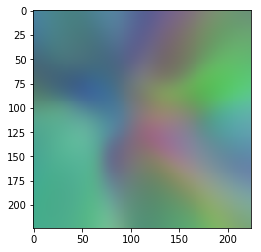





  0%|          | 1/500 [00:00<03:09,  2.63it/s]



  1%|          | 3/500 [00:00<02:31,  3.27it/s]



  1%|          | 4/500 [00:00<02:17,  3.61it/s]



  1%|          | 5/500 [00:01<02:06,  3.92it/s]



  1%|          | 6/500 [00:01<01:58,  4.18it/s]



  1%|▏         | 7/500 [00:01<01:53,  4.34it/s]



  2%|▏         | 8/500 [00:01<01:49,  4.50it/s]



  2%|▏         | 9/500 [00:01<01:46,  4.62it/s]



  2%|▏         | 10/500 [00:02<01:44,  4.70it/s]



  2%|▏         | 11/500 [00:02<01:43,  4.74it/s]



  2%|▏         | 12/500 [00:02<01:42,  4.78it/s]



  3%|▎         | 13/500 [00:02<01:41,  4.80it/s]



  3%|▎         | 14/500 [00:02<01:40,  4.82it/s]



  3%|▎         | 15/500 [00:03<01:40,  4.85it/s]



  3%|▎         | 16/500 [00:03<01:40,  4.82it/s]



  3%|▎         | 17/500 [00:03<01:39,  4.84it/s]



  4%|▎         | 18/500 [00:03<01:38,  4.88it/s]



  4%|▍         | 19/500 [00:03<01:38,  4.86it/s]



  4%|▍         | 20/500 [00:04<01:38,  4.87it/s]



  4%|▍         |

cost -2.370812177658081


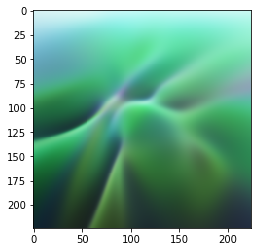





 10%|█         | 51/500 [00:10<02:12,  3.40it/s]



 11%|█         | 53/500 [00:11<01:49,  4.09it/s]



 11%|█         | 54/500 [00:11<01:44,  4.26it/s]



 11%|█         | 55/500 [00:11<01:39,  4.45it/s]



 11%|█         | 56/500 [00:11<01:37,  4.54it/s]



 11%|█▏        | 57/500 [00:11<01:35,  4.63it/s]



 12%|█▏        | 58/500 [00:12<01:33,  4.70it/s]



 12%|█▏        | 59/500 [00:12<01:32,  4.75it/s]



 12%|█▏        | 60/500 [00:12<01:32,  4.74it/s]



 12%|█▏        | 61/500 [00:12<01:30,  4.84it/s]



 12%|█▏        | 62/500 [00:12<01:30,  4.83it/s]



 13%|█▎        | 63/500 [00:13<01:30,  4.85it/s]



 13%|█▎        | 64/500 [00:13<01:30,  4.83it/s]



 13%|█▎        | 65/500 [00:13<01:29,  4.86it/s]



 13%|█▎        | 66/500 [00:13<01:29,  4.83it/s]



 13%|█▎        | 67/500 [00:13<01:29,  4.85it/s]



 14%|█▎        | 68/500 [00:14<01:28,  4.86it/s]



 14%|█▍        | 69/500 [00:14<01:28,  4.86it/s]



 14%|█▍        | 70/500 [00:14<01:28,  4.85it/s]



 14%|█▍ 

cost -3.7934675216674805


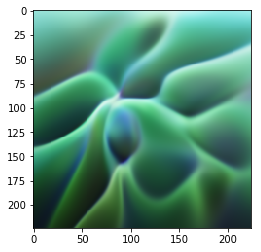





 20%|██        | 101/500 [00:21<01:57,  3.38it/s]



 21%|██        | 103/500 [00:21<01:37,  4.06it/s]



 21%|██        | 104/500 [00:21<01:32,  4.27it/s]



 21%|██        | 105/500 [00:21<01:29,  4.43it/s]



 21%|██        | 106/500 [00:22<01:26,  4.55it/s]



 21%|██▏       | 107/500 [00:22<01:24,  4.65it/s]



 22%|██▏       | 108/500 [00:22<01:23,  4.67it/s]



 22%|██▏       | 109/500 [00:22<01:22,  4.76it/s]



 22%|██▏       | 110/500 [00:22<01:21,  4.78it/s]



 22%|██▏       | 111/500 [00:23<01:20,  4.82it/s]



 22%|██▏       | 112/500 [00:23<01:20,  4.83it/s]



 23%|██▎       | 113/500 [00:23<01:20,  4.82it/s]



 23%|██▎       | 114/500 [00:23<01:19,  4.84it/s]



 23%|██▎       | 115/500 [00:24<01:19,  4.86it/s]



 23%|██▎       | 116/500 [00:24<01:19,  4.84it/s]



 23%|██▎       | 117/500 [00:24<01:18,  4.85it/s]



 24%|██▎       | 118/500 [00:24<01:18,  4.85it/s]



 24%|██▍       | 119/500 [00:24<01:17,  4.89it/s]



 24%|██▍       | 120/500 [00:25<01:18,  4.

cost -4.75482702255249


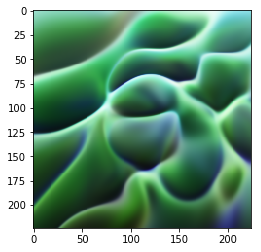





 30%|███       | 151/500 [00:31<01:43,  3.38it/s]



 31%|███       | 153/500 [00:31<01:25,  4.05it/s]



 31%|███       | 154/500 [00:32<01:21,  4.26it/s]



 31%|███       | 155/500 [00:32<01:18,  4.39it/s]



 31%|███       | 156/500 [00:32<01:16,  4.53it/s]



 31%|███▏      | 157/500 [00:32<01:18,  4.36it/s]



 32%|███▏      | 158/500 [00:33<01:15,  4.50it/s]



 32%|███▏      | 159/500 [00:33<01:13,  4.61it/s]



 32%|███▏      | 160/500 [00:33<01:12,  4.66it/s]



 32%|███▏      | 161/500 [00:33<01:11,  4.73it/s]



 32%|███▏      | 162/500 [00:33<01:10,  4.76it/s]



 33%|███▎      | 163/500 [00:34<01:10,  4.79it/s]



 33%|███▎      | 164/500 [00:34<01:09,  4.82it/s]



 33%|███▎      | 165/500 [00:34<01:09,  4.81it/s]



 33%|███▎      | 166/500 [00:34<01:08,  4.85it/s]



 33%|███▎      | 167/500 [00:34<01:09,  4.82it/s]



 34%|███▎      | 168/500 [00:35<01:08,  4.85it/s]



 34%|███▍      | 169/500 [00:35<01:08,  4.84it/s]



 34%|███▍      | 170/500 [00:35<01:08,  4.

cost -5.504879474639893


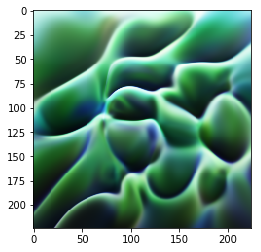





 40%|████      | 201/500 [00:42<01:28,  3.38it/s]



 41%|████      | 203/500 [00:42<01:13,  4.04it/s]



 41%|████      | 204/500 [00:42<01:09,  4.26it/s]



 41%|████      | 205/500 [00:42<01:06,  4.42it/s]



 41%|████      | 206/500 [00:43<01:04,  4.56it/s]



 41%|████▏     | 207/500 [00:43<01:03,  4.65it/s]



 42%|████▏     | 208/500 [00:43<01:02,  4.68it/s]



 42%|████▏     | 209/500 [00:43<01:01,  4.75it/s]



 42%|████▏     | 210/500 [00:43<01:00,  4.82it/s]



 42%|████▏     | 211/500 [00:44<00:59,  4.83it/s]



 42%|████▏     | 212/500 [00:44<00:59,  4.82it/s]



 43%|████▎     | 213/500 [00:44<00:59,  4.83it/s]



 43%|████▎     | 214/500 [00:44<00:59,  4.85it/s]



 43%|████▎     | 215/500 [00:44<00:58,  4.87it/s]



 43%|████▎     | 216/500 [00:45<00:58,  4.88it/s]



 43%|████▎     | 217/500 [00:45<00:58,  4.85it/s]



 44%|████▎     | 218/500 [00:45<00:57,  4.86it/s]



 44%|████▍     | 219/500 [00:45<01:01,  4.58it/s]



 44%|████▍     | 220/500 [00:45<00:59,  4.

cost -6.080725193023682


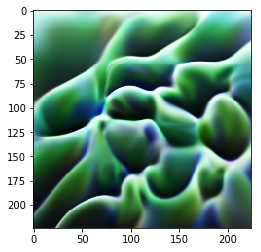





 50%|█████     | 251/500 [00:52<01:14,  3.34it/s]



 51%|█████     | 253/500 [00:52<01:01,  4.01it/s]



 51%|█████     | 254/500 [00:53<00:58,  4.23it/s]



 51%|█████     | 255/500 [00:53<00:55,  4.40it/s]



 51%|█████     | 256/500 [00:53<00:54,  4.52it/s]



 51%|█████▏    | 257/500 [00:53<00:52,  4.64it/s]



 52%|█████▏    | 258/500 [00:53<00:51,  4.70it/s]



 52%|█████▏    | 259/500 [00:54<00:51,  4.72it/s]



 52%|█████▏    | 260/500 [00:54<00:50,  4.79it/s]



 52%|█████▏    | 261/500 [00:54<00:49,  4.78it/s]



 52%|█████▏    | 262/500 [00:54<00:49,  4.81it/s]



 53%|█████▎    | 263/500 [00:55<00:48,  4.84it/s]



 53%|█████▎    | 264/500 [00:55<00:48,  4.87it/s]



 53%|█████▎    | 265/500 [00:55<00:48,  4.84it/s]



 53%|█████▎    | 266/500 [00:55<00:48,  4.86it/s]



 53%|█████▎    | 267/500 [00:55<00:47,  4.89it/s]



 54%|█████▎    | 268/500 [00:56<00:47,  4.84it/s]



 54%|█████▍    | 269/500 [00:56<00:47,  4.86it/s]



 54%|█████▍    | 270/500 [00:56<00:47,  4.

cost -6.550909519195557


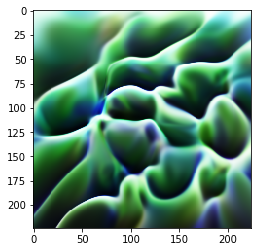





 60%|██████    | 301/500 [01:03<00:59,  3.36it/s]



 61%|██████    | 303/500 [01:03<00:48,  4.03it/s]



 61%|██████    | 304/500 [01:03<00:45,  4.27it/s]



 61%|██████    | 305/500 [01:03<00:44,  4.42it/s]



 61%|██████    | 306/500 [01:04<00:42,  4.54it/s]



 61%|██████▏   | 307/500 [01:04<00:41,  4.65it/s]



 62%|██████▏   | 308/500 [01:04<00:40,  4.69it/s]



 62%|██████▏   | 309/500 [01:04<00:40,  4.74it/s]



 62%|██████▏   | 310/500 [01:04<00:39,  4.76it/s]



 62%|██████▏   | 311/500 [01:05<00:39,  4.83it/s]



 62%|██████▏   | 312/500 [01:05<00:38,  4.82it/s]



 63%|██████▎   | 313/500 [01:05<00:38,  4.83it/s]



 63%|██████▎   | 314/500 [01:05<00:38,  4.84it/s]



 63%|██████▎   | 315/500 [01:05<00:38,  4.81it/s]



 63%|██████▎   | 316/500 [01:06<00:37,  4.87it/s]



 63%|██████▎   | 317/500 [01:06<00:37,  4.83it/s]



 64%|██████▎   | 318/500 [01:06<00:37,  4.82it/s]



 64%|██████▍   | 319/500 [01:06<00:37,  4.89it/s]



 64%|██████▍   | 320/500 [01:06<00:37,  4.

cost -6.888993740081787


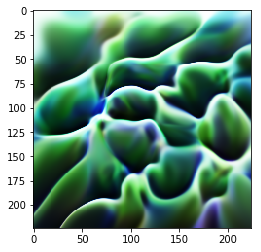





 70%|███████   | 351/500 [01:13<00:44,  3.32it/s]



 71%|███████   | 353/500 [01:13<00:36,  4.00it/s]



 71%|███████   | 354/500 [01:14<00:34,  4.22it/s]



 71%|███████   | 355/500 [01:14<00:32,  4.40it/s]



 71%|███████   | 356/500 [01:14<00:31,  4.53it/s]



 71%|███████▏  | 357/500 [01:14<00:31,  4.61it/s]



 72%|███████▏  | 358/500 [01:14<00:30,  4.65it/s]



 72%|███████▏  | 359/500 [01:15<00:29,  4.72it/s]



 72%|███████▏  | 360/500 [01:15<00:29,  4.79it/s]



 72%|███████▏  | 361/500 [01:15<00:29,  4.79it/s]



 72%|███████▏  | 362/500 [01:15<00:28,  4.83it/s]



 73%|███████▎  | 363/500 [01:16<00:28,  4.78it/s]



 73%|███████▎  | 364/500 [01:16<00:28,  4.84it/s]



 73%|███████▎  | 365/500 [01:16<00:27,  4.87it/s]



 73%|███████▎  | 366/500 [01:16<00:27,  4.82it/s]



 73%|███████▎  | 367/500 [01:16<00:27,  4.84it/s]



 74%|███████▎  | 368/500 [01:17<00:27,  4.87it/s]



 74%|███████▍  | 369/500 [01:17<00:26,  4.90it/s]



 74%|███████▍  | 370/500 [01:17<00:26,  4.

cost -7.139317989349365


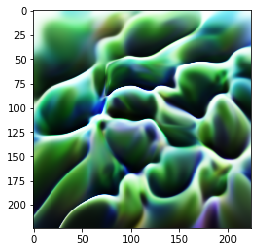





 80%|████████  | 401/500 [01:24<00:29,  3.36it/s]



 81%|████████  | 403/500 [01:24<00:24,  4.03it/s]



 81%|████████  | 404/500 [01:24<00:24,  3.96it/s]



 81%|████████  | 405/500 [01:24<00:21,  4.34it/s]



 81%|████████  | 406/500 [01:25<00:20,  4.50it/s]



 81%|████████▏ | 407/500 [01:25<00:20,  4.59it/s]



 82%|████████▏ | 408/500 [01:25<00:19,  4.67it/s]



 82%|████████▏ | 409/500 [01:25<00:19,  4.73it/s]



 82%|████████▏ | 410/500 [01:25<00:18,  4.76it/s]



 82%|████████▏ | 411/500 [01:26<00:18,  4.79it/s]



 82%|████████▏ | 412/500 [01:26<00:18,  4.82it/s]



 83%|████████▎ | 413/500 [01:26<00:17,  4.85it/s]



 83%|████████▎ | 414/500 [01:26<00:17,  4.82it/s]



 83%|████████▎ | 415/500 [01:26<00:17,  4.85it/s]



 83%|████████▎ | 416/500 [01:27<00:17,  4.85it/s]



 83%|████████▎ | 417/500 [01:27<00:17,  4.85it/s]



 84%|████████▎ | 418/500 [01:27<00:16,  4.87it/s]



 84%|████████▍ | 419/500 [01:27<00:16,  4.87it/s]



 84%|████████▍ | 420/500 [01:27<00:16,  4.

cost -7.334615707397461


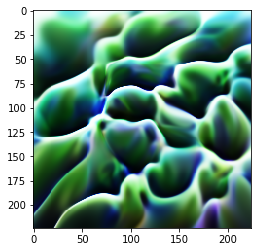





 90%|█████████ | 451/500 [01:34<00:14,  3.37it/s]



 91%|█████████ | 453/500 [01:34<00:11,  4.07it/s]



 91%|█████████ | 454/500 [01:35<00:10,  4.24it/s]



 91%|█████████ | 455/500 [01:35<00:10,  4.42it/s]



 91%|█████████ | 456/500 [01:35<00:09,  4.54it/s]



 91%|█████████▏| 457/500 [01:35<00:09,  4.66it/s]



 92%|█████████▏| 458/500 [01:35<00:08,  4.69it/s]



 92%|█████████▏| 459/500 [01:36<00:08,  4.75it/s]



 92%|█████████▏| 460/500 [01:36<00:08,  4.78it/s]



 92%|█████████▏| 461/500 [01:36<00:08,  4.79it/s]



 92%|█████████▏| 462/500 [01:36<00:07,  4.81it/s]



 93%|█████████▎| 463/500 [01:36<00:07,  4.86it/s]



 93%|█████████▎| 464/500 [01:37<00:07,  4.84it/s]



 93%|█████████▎| 465/500 [01:37<00:07,  4.87it/s]



 93%|█████████▎| 466/500 [01:37<00:07,  4.82it/s]



 93%|█████████▎| 467/500 [01:37<00:06,  4.88it/s]



 94%|█████████▎| 468/500 [01:37<00:06,  4.88it/s]



 94%|█████████▍| 469/500 [01:38<00:06,  4.61it/s]



 94%|█████████▍| 470/500 [01:38<00:06,  4.

Took 104.55630564689636 seconds


In [93]:
size = [224, 224]
chan_to_opt = 2

log_interval = 50
widths = [24] * 8

now = time.time()
print('Training {}'.format(chan_to_opt))
viz = train(size, widths, imagenet_model, chan_to_opt, log_interval)
print('Took {} seconds'.format(time.time() - now))
now = time.time()

In [94]:
from dreamz.utils import tch_im_to_pil
ims_savedir = '../data/output_ims3/'
bigsize = [1080//2, 1080//2]
def big_save_fn(alpha = 0.0):
    xy_big = get_xy_mesh(bigsize).to(device)
#     xy_big = get_xy_mesh([1080, 1920]).to(device)
    alpha = torch.FloatTensor([alpha]).to(device).view(1, 1, 1, 1).repeat([1, 1, *xy_big.shape[-2:]])
    res = viz(torch.cat([xy_big, alpha], 1))
#     imsave(get_latest_filename(ims_savedir), tch_im_to_np(res))
    return (tch_im_to_np(res))

In [95]:
import numpy as np
from PIL import Image, ImageDraw
import cv2
from tqdm import tqdm

fourcc = cv2.VideoWriter_fourcc('M','J','P','G')
video = cv2.VideoWriter('test.mp4', fourcc, 60, (540, 540))
for alpha in (np.linspace(-2, 2, 400)):
    im_np = big_save_fn(alpha)
    video.write(cv2.cvtColor(im_np, cv2.COLOR_RGB2BGR))
video.release()